<a href="https://colab.research.google.com/github/leechanhoe/deep-learning-project/blob/master/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

import pickle
import numpy as np
import matplotlib.pyplot as plt

In [69]:
def load_data(data, labels):
    # 데이터셋의 이미지 개수
    num_images = data.shape[0]

     # (10000, 3072) 형태인 데이터를 (10000, 3, 32, 32) 형태로 변경
    images = np.reshape(data, (num_images, 32, 32, 3), order='F')

    # (10000, 3, 32, 32) 형태의 이미지 데이터를 (10000, 32, 32, 3)로 변경
    images = np.swapaxes(images, 1, 2)
    
    # 레이블과 함께 튜플로 반환
    return images, labels

In [70]:
def pre_process(data): 
    images, lbls = load_data(data[b'data'], data[b'labels'])
    images = images.astype('float32') / 255.

    x_train, x_test, y_train, y_test = train_test_split(images, lbls, test_size=0.2)

    y_train = np.array(y_train)
    y_test = np.array(y_test)
    return x_train, x_test, y_train, y_test

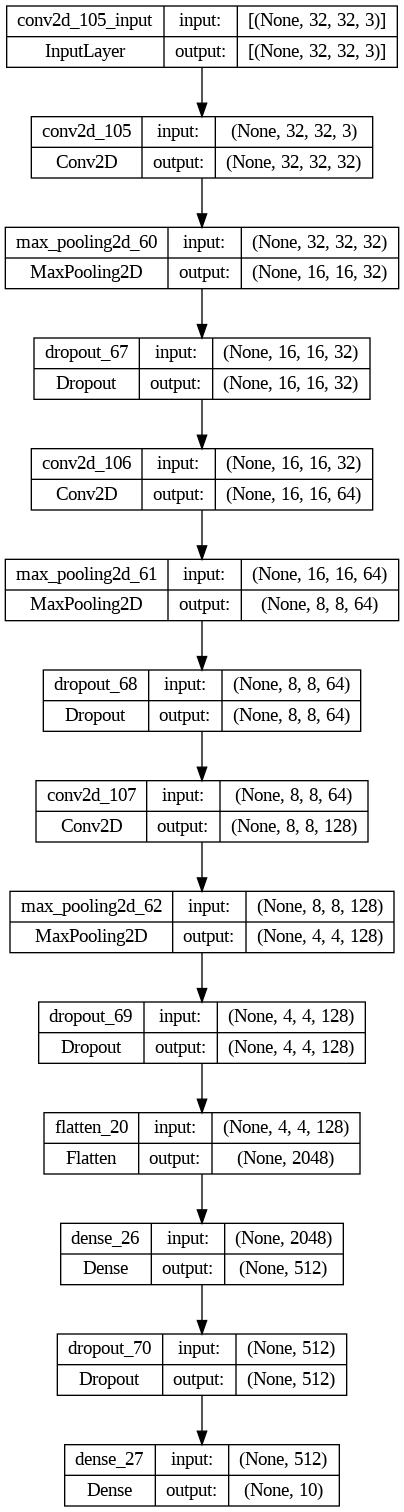

In [71]:
def create_cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    return model

model = create_cnn_model()
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
keras.utils.plot_model(model, show_shapes=True)

In [72]:
def merge_data(filepaths):
    x_all_train, y_all_train = [], []

    for filepath in filepaths:
        with open(filepath, 'rb') as f:
            data = pickle.load(f, encoding='bytes')

        x_train, x_test, y_train, y_test = pre_process(data)

        x_all_train.append(x_train)
        y_all_train.append(y_train)

    x_train_merged = np.concatenate(x_all_train, axis=0)
    y_train_merged = np.concatenate(y_all_train, axis=0)

    return x_train_merged, y_train_merged

In [73]:
def train(model, filepaths, epochs=30, batch_size=64, callback=[]):
  
    history = []
    for filepath in filepaths:
        # 데이터 로드 및 전처리
        with open(filepath, 'rb') as f:
            data = pickle.load(f, encoding='bytes')

        x_train, x_test, y_train, y_test = pre_process(data)

        # 모델 학습
        history.append(model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), callbacks=callback))
    return model, history

In [79]:
def plot_history(history_list):
    plt.figure(figsize=(12, 4))

    epochs_since_beginning = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for i, h in enumerate(history_list):
        epochs = range(epochs_since_beginning, epochs_since_beginning + len(h.history['loss']))
        epochs_since_beginning += len(h.history['loss'])

        train_losses += h.history['loss']
        train_accuracies += h.history['accuracy']
        val_losses += h.history['val_loss']
        val_accuracies += h.history['val_accuracy']

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1/2
125/125 [==============================] - 27s 213ms/step - loss: 1.4286 - accuracy: 0.4840 - val_loss: 1.4225 - val_accuracy: 0.4805
Epoch 2/2
125/125 [==============================] - 26s 207ms/step - loss: 1.4068 - accuracy: 0.4910 - val_loss: 1.3929 - val_accuracy: 0.4915
Epoch 1/2
125/125 [==============================] - 27s 213ms/step - loss: 1.4286 - accuracy: 0.4870 - val_loss: 1.3723 - val_accuracy: 0.5135
Epoch 2/2
125/125 [==============================] - 28s 222ms/step - loss: 1.4089 - accuracy: 0.4990 - val_loss: 1.3639 - val_accuracy: 0.5220
Epoch 1/2
125/125 [==============================] - 28s 225ms/step - loss: 1.3605 - accuracy: 0.5096 - val_loss: 1.3108 - val_accuracy: 0.5345
Epoch 2/2
125/125 [==============================] - 26s 212ms/step - loss: 1.3526 - accuracy: 0.5082 - val_loss: 1.3001 - val_accuracy: 0.5430
Epoch 1/2
125/125 [==============================] - 28s 223ms/step - loss: 1.3848 - accuracy: 0.4996 - val_loss: 1.3391 - val_accuracy:

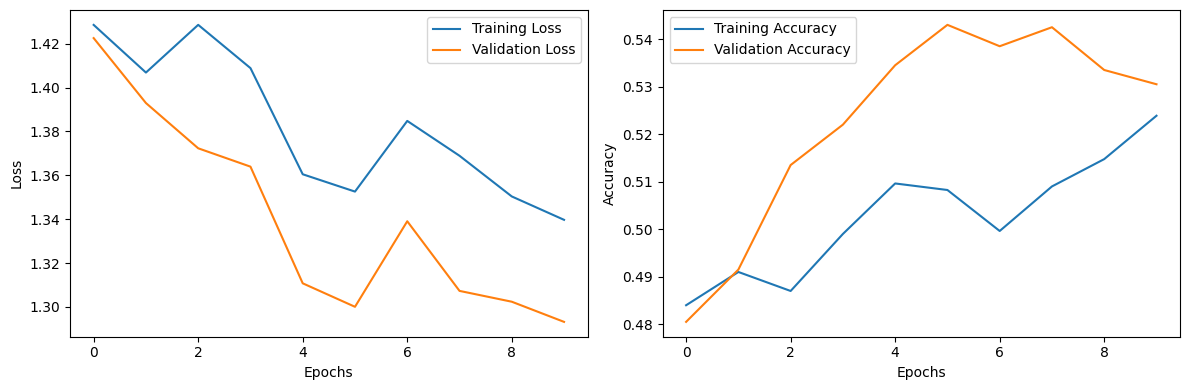

In [80]:
file_name = ['/content/drive/MyDrive/Colab Notebooks/data/data_batch_1',
    '/content/drive/MyDrive/Colab Notebooks/data/data_batch_2',
    '/content/drive/MyDrive/Colab Notebooks/data/data_batch_3',
    '/content/drive/MyDrive/Colab Notebooks/data/data_batch_4',
    '/content/drive/MyDrive/Colab Notebooks/data/data_batch_5']

checkpoint = keras.callbacks.ModelCheckpoint('best_cnn_model.h5', save_best_only=True)
# 5번의 연속적인 epoch 동안 개선이 없을 때 학습이 중단되도록 함
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

scheduler1 = LearningRateScheduler(custom_lr_schedule(0.001, 0.9)) # 뒤로 갈수록 학습률 작게 조정
callbacks = [checkpoint, early_stopping, scheduler1]
model, history = train(model, file_name, epochs=2, batch_size=64, callback=callback)
plot_history(history)

scheduler2 = LearningRateScheduler(custom_lr_schedule(0.0005, 0.9))
callbacks = [checkpoint, early_stopping, scheduler2]
model, history = train(model, file_name, epochs=10, batch_size=64, callback=callback)
plot_history(history)

scheduler3 = LearningRateScheduler(custom_lr_schedule(0.0003, 0.9))
callbacks = [checkpoint, early_stopping, scheduler3]
model, history = train(model, file_name, epochs=10, batch_size=64, callback=callback)

scheduler4 = LearningRateScheduler(custom_lr_schedule(0.0001, 0.9))
callbacks = [checkpoint, early_stopping, scheduler4]
# model, history = train(model, file_name, epochs=10, batch_size=64, callback=callback)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/data/test_batch', 'rb') as f:
    data = pickle.load(f, encoding='bytes')

x_train, x_test, y_train, y_test = pre_process(data)

In [15]:
# 모델 평가
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
# model.save('0.727.h5')

63/63 [==============================] - 4s 61ms/step - loss: 0.9397 - accuracy: 0.6730
Test loss: 0.9397317171096802
Test accuracy: 0.6729999780654907


In [ ]:
for i in range(len(history)):
    plt.plot(history[i].history['loss'])
    plt.plot(history[i].history['val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train', 'val'])
    plt.show()

In [ ]:
plt.imshow(x_test[0].reshape(32, 32, 3))
plt.show()